# Glove Manufacturing Improvement

The glove manufacturer experiences a disqualification rate around 3%. The disqualification is defined as the absolute weight difference (real weight - required weight) larger than 10% of the required weight.  

The data set includes the manufacturing data from 2021.01 to 2022.03. I will try to analyze the data using decision tree method.  

The data were processed through ETL and then analyzed with a decision tree classifier model.

In short summary, the take-home message are:
1. The **weight change** has a determinant impact on the disqualification.  
1. A **negative weight change more than 0.2** leads to a dramastic increase in disqualification ratio.  


## 1. Extract the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Combine all the data sheets in the excel files

gloves_raw = pd.concat(pd.read_excel('gloves_all.xlsx', sheet_name=None), 
                      ignore_index=True)
gloves_raw.head()

,日期,时段,班别,线别,克重标准,面别,型号,克重\n(g),腕部厚度\n(mm),掌心厚度\n(mm),指尖厚度\n(mm),拉断力1\n(N),拉断强度1\n(MPa),拉断伸长率1\n(%),拉断力2\n(N),拉断强度2\n(MPa),拉断伸长率2\n(%),平均克重\n(g)
0,2021-01-10,8,B白,1#,4.5,A1,M,4.45,0.048,0.06,0.0615,7.527,20.909,361.557,NaN,NaN,NaN,4.4115
1,2021-01-10,8,B白,1#,4.5,A2,M,4.373,0.044,0.066,0.0825,8.734,24.260,327.546,NaN,NaN,NaN,NaN
2,2021-01-10,8,B白,1#,4.5,B2,M,4.484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.4765
3,2021-01-10,8,B白,1#,4.5,B1,M,4.469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-10,8,B白,2#,4.6,A1,L,4.54,0.039,0.07,0.0500,7.44,20.667,322.079,NaN,NaN,NaN,4.5365


## 2. Transform the data

In [3]:
# Rename the column names

dict = {'日期': 'Date', '时段': 'Time', '班别': 'Shift','线别': 'ProductionLine', 
        '克重标准': 'RequiredWeight', '面别': 'Surface', '型号': 'Type', 
        '克重\n(g)': 'RealWeight', '腕部厚度\n(mm)': 'WristThickness', 
        '掌心厚度\n(mm)': 'PalmThickness', '指尖厚度\n(mm)': 'FingerThickness', 
       '拉断力1\n(N)': 'BreakingForce1', '拉断力2\n(N)': 'BreakingForce2', '拉断强度1\n(MPa)': 'TensileStress1', 
       '拉断伸长率1\n(%)': 'TensileStrain1', '拉断强度2\n(MPa)': 'TensileStress2',
       '拉断伸长率2\n(%)': 'TensileStrain2', '平均克重\n(g)': 'AverageWeight'}
gloves_raw.rename(columns=dict, inplace=True)

In [4]:
# Select the interested features

gloves_refined = gloves_raw[['Date', 'Time', 'Shift', 'ProductionLine', 'RequiredWeight', 'Surface', 'RealWeight']]
gloves_refined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51276 entries, 0 to 51275
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            51276 non-null  datetime64[ns]
 1   Time            51276 non-null  int64         
 2   Shift           51276 non-null  object        
 3   ProductionLine  51276 non-null  object        
 4   RequiredWeight  51276 non-null  object        
 5   Surface         51276 non-null  object        
 6   RealWeight      49499 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 2.7+ MB


In [5]:
# Drop the missing values in the real weight column

gloves_refined = gloves_refined.dropna(subset=['RealWeight'])

In [6]:
# The required weight changed sometime during the manufacturing process

gloves_refined['RequiredWeight'].unique()

array([4.5, 4.6, 4.9, 5.5, 5, 5.2, '5.5升5.7', 5.7, '5.7降5.5', '4.5降4.2',
       4.2, '4.6降4.4', 4.4, '5.0升5.1', 5.1, '4.9降4.7', 4.7, '4.7升5.1',
       '5.1降5.0', '4.2升4.3', 4.3, '4.3升4.5', '5.1降4.9', '5.0降4.6',
       '4.6升5.0', '5.2升5.4', '4.5降4.3', 5.4, '5.0升5.2', '4.3降4.2',
       '4.7升4.9', '5.2降5.0', '5.7降4.6', '5.4降5.2', '4.2升4.5', '5.4降5.3',
       5.3, '4.9降4.8', 4.8, '4.8升5.1', '5.3升5.4', '5.1降4.8', '4.8升4.9',
       '4.9升5.1', '5.1升5.4', '5.4降5.1', '5.2降5.1', '4.9升5.2', '5.2降4.9',
       '5.4升5.7', '5.7降5.4', '5.4升5.6', 5.6, '5.6降5.4', '5.1升5.3',
       '5.4升5.8', 5.8, '5.8降5.4', '5.3降4.8', '4.8升5.3', '5.2升5.3',
       '5.3降5.1', '5.3降5.2', '4.6升5.3', '4.4升5.0', '5.1升5.2', '4.8降4.5',
       '5.3升5.5', '5.0降4.4', '4.5升4.8', '5.0升5.3', '4.8降4.2', '4.7升4.8',
       '4.8降4.7', '5.8升6.3', '4.6升4.8', 6.3, '4.8升4.7', '6.3降6.0', 6,
       '4.8降4.4', '5降4.9', '6.3降5.5', '4.9升5.3', '5.6升6.3', '6.0升6.3',
       '6.3降5.9', 5.9, '5.9升6.3', '4.4升4.8', '4.8降4.3', '4.3升4.8',
       '4.3升4.4'

In [7]:
# Identify the weights before and after change
# Record the value in two columns of ChangeFrom and ChangeTo, respectively
# The weight value has three formats: i.e. 5.1, 5, 5.1升5.3
# Use regular expression to extract the numbers 
# \d+ means match a digit 1 or more times
# \.? means match a dot 0 or 1 time
# \d* means match a digit o or more times
# With the help of the regex I can extract all the number with three different formats

gloves_refined[['ChangeFrom', 'ChangeTo']] = gloves_refined['RequiredWeight'].astype('str').str.extractall(r'(\d+\.?\d*)').unstack()

In [8]:
# Fill the ChangeTo column with the value of the ChangeFrom if missing

gloves_refined['ChangeTo'] = gloves_refined['ChangeTo'].fillna(
    gloves_refined['ChangeFrom'])

In [9]:
# Record the weight change in the WeightChange column

gloves_refined['ChangeFrom'] = gloves_refined['ChangeFrom'].astype(float)
gloves_refined['ChangeTo'] = gloves_refined['ChangeTo'].astype(float)
gloves_refined['WeightChange'] = gloves_refined['ChangeTo'] - gloves_refined['ChangeFrom']
gloves_refined.head()

,Date,Time,Shift,ProductionLine,RequiredWeight,Surface,RealWeight,ChangeFrom,ChangeTo,WeightChange
0,2021-01-10,8,B白,1#,4.5,A1,4.45,4.5,4.5,0.0
1,2021-01-10,8,B白,1#,4.5,A2,4.373,4.5,4.5,0.0
2,2021-01-10,8,B白,1#,4.5,B2,4.484,4.5,4.5,0.0
3,2021-01-10,8,B白,1#,4.5,B1,4.469,4.5,4.5,0.0
4,2021-01-10,8,B白,2#,4.6,A1,4.54,4.6,4.6,0.0


In [10]:
# Record the weight difference between the required weight and the real weight

gloves_refined = gloves_refined[gloves_refined['RealWeight'] != "  "]
gloves_refined['RealWeight'] = gloves_refined['RealWeight'].astype(float)
gloves_refined['WeightDiff'] = gloves_refined['RealWeight'] - gloves_refined['ChangeTo']
gloves_refined = gloves_refined.drop(columns=['RequiredWeight'])

In [11]:
gloves_refined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49498 entries, 0 to 51275
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            49498 non-null  datetime64[ns]
 1   Time            49498 non-null  int64         
 2   Shift           49498 non-null  object        
 3   ProductionLine  49498 non-null  object        
 4   Surface         49498 non-null  object        
 5   RealWeight      49498 non-null  float64       
 6   ChangeFrom      49498 non-null  float64       
 7   ChangeTo        49498 non-null  float64       
 8   WeightChange    49498 non-null  float64       
 9   WeightDiff      49498 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 4.2+ MB


In [65]:
# Create dummy variables for model building

gloves_final = pd.get_dummies(gloves_refined,
                             columns=['Time', 'Shift', 
                                      'ProductionLine', 'Surface'], 
                             drop_first=True)
gloves_final = pd.concat([gloves_final, gloves_refined[['Time', 'Shift', 
                                      'ProductionLine', 'Surface']]], axis=1)
gloves_final.head()

,Date,RealWeight,ChangeFrom,ChangeTo,WeightChange,WeightDiff,Time_1,Time_2,Time_3,Time_4,...,ProductionLine_9#,Surface_A1,Surface_A2,Surface_B,Surface_B1,Surface_B2,Time,Shift,ProductionLine,Surface
0,2021-01-10,4.450,4.5,4.5,0.0,-0.050,0,0,0,0,...,0,1,0,0,0,0,8,B白,1#,A1
1,2021-01-10,4.373,4.5,4.5,0.0,-0.127,0,0,0,0,...,0,0,1,0,0,0,8,B白,1#,A2
2,2021-01-10,4.484,4.5,4.5,0.0,-0.016,0,0,0,0,...,0,0,0,0,0,1,8,B白,1#,B2
3,2021-01-10,4.469,4.5,4.5,0.0,-0.031,0,0,0,0,...,0,0,0,0,1,0,8,B白,1#,B1
4,2021-01-10,4.540,4.6,4.6,0.0,-0.060,0,0,0,0,...,0,1,0,0,0,0,8,B白,2#,A1


## 3. Load the data

In [13]:
import time

# Record the loading time for future reference

start = time.time()

gloves_final.to_excel('gloves_ETL.xlsx')

end = time.time()
print('The loading time is {:.2f} seconds'. format(end - start))

The loading time is 49.19 seconds


## 4. Build the model

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [66]:
# Differentiate the qualified and disqualified gloves

gloves_final['Disqualification'] = (gloves_final['WeightDiff']/gloves_final['ChangeTo']) >= 0.1

qualified = gloves_final['Disqualification'] == False
disqualified = gloves_final['Disqualification'] == True

gloves_qualified = gloves_final[qualified]
gloves_disqualified = gloves_final[disqualified]
gloves_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49498 entries, 0 to 51275
Data columns (total 55 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                49498 non-null  datetime64[ns]
 1   RealWeight          49498 non-null  float64       
 2   ChangeFrom          49498 non-null  float64       
 3   ChangeTo            49498 non-null  float64       
 4   WeightChange        49498 non-null  float64       
 5   WeightDiff          49498 non-null  float64       
 6   Time_1              49498 non-null  uint8         
 7   Time_2              49498 non-null  uint8         
 8   Time_3              49498 non-null  uint8         
 9   Time_4              49498 non-null  uint8         
 10  Time_5              49498 non-null  uint8         
 11  Time_6              49498 non-null  uint8         
 12  Time_7              49498 non-null  uint8         
 13  Time_8              49498 non-null  uint8     

In [68]:
start = time.time()

X = gloves_final.drop(columns=['Date', 'Disqualification', 'WeightDiff', 'RealWeight',
                              'Time', 'Shift', 'ProductionLine', 'Surface']).values
y = gloves_final['Disqualification'].values

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, stratify=y)

param_grid = {'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
             'criterion': ['gini', 'entropy'],
             'max_depth': [1, 10, 20, 50]}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=param_grid, scoring='recall', cv=StratifiedKFold(n_splits=5))
grid.fit(X_trainval, y_trainval)

print('Grid Search with recall:')
print('Best parameters: ', grid.best_params_)
print('Best cross-validation score(recall): {:.3f}'.format(grid.best_score_))
print('Test AUC: {:.3f}'.format(roc_auc_score(y_test, grid.predict(X_test))))
confusion = confusion_matrix(grid.predict(X_test), y_test)
print('The confusion matrix is: \n {}'.format(confusion))

end = time.time()
print('The processing time is: {:.2f} seconds'.format(end - start))

Grid Search with recall:
Best parameters:  {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1}
Best cross-validation score(recall): 0.309
Test AUC: 0.691
The confusion matrix is: 
 [[12329    21]
 [   12    13]]
The processing time is: 118.64 seconds


Text(0.5, 0, 'Impurity Decrease')

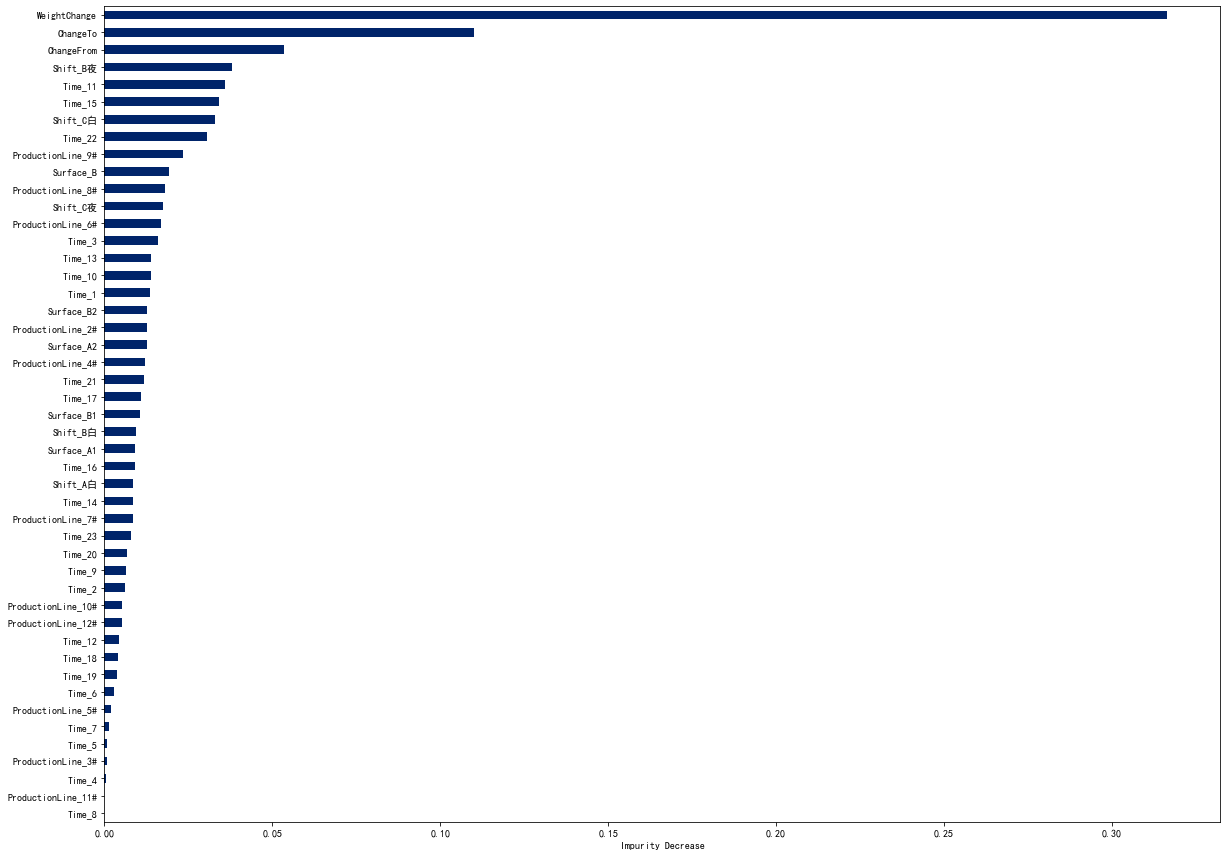

In [128]:
# It can be found that weight change before and after has a significant impact on the classifier

# Support Chinese characters
plt.rcParams['font.sans-serif'] = ['SimHei']
# Fix minus sign problem
plt.rcParams['axes.unicode_minus'] = False

dtc = grid.best_estimator_
fea_imp = dtc.feature_importances_

var_imp = pd.Series(fea_imp, gloves_final.drop(columns=['Date', 'Disqualification', 'WeightDiff', 'RealWeight', 
                                                       'Time', 'Shift', 'ProductionLine', 'Surface']).columns)
plt.figure(figsize=(20, 15))
var_imp.sort_values().plot.barh(color='#00246A')
plt.xlabel('Impurity Decrease')

## 5. Analyze the data

### 5.1. When disqualification happens

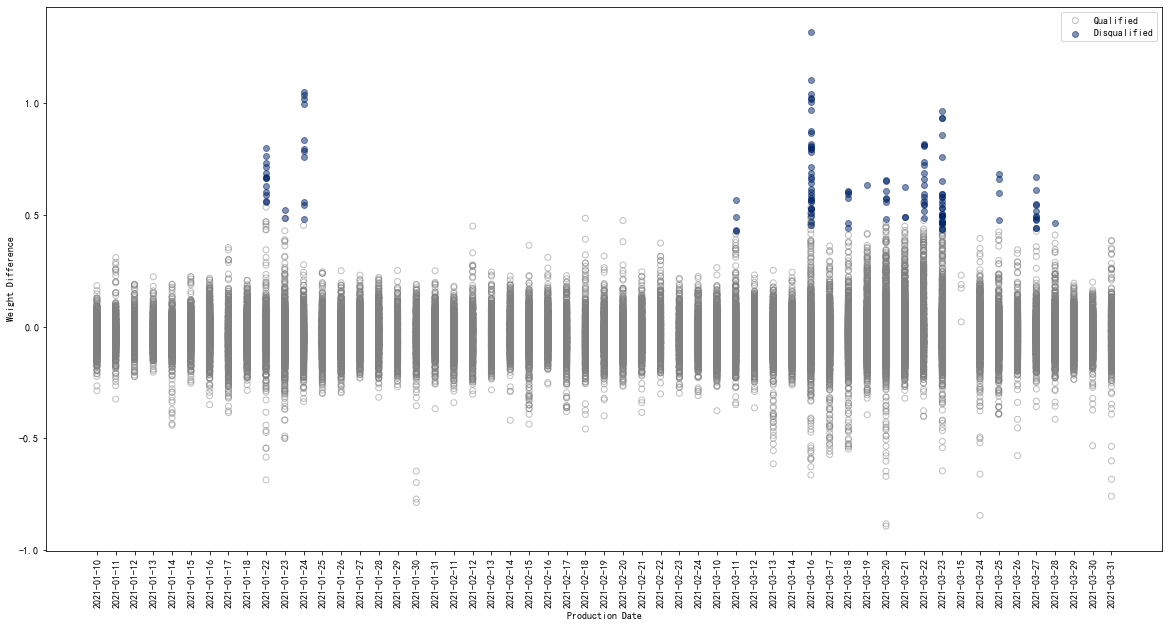

In [130]:
# It can be seen that disqualification happened in Jan and March only
# All the disqualified gloves have positive weight difference values.

plt.figure(figsize=(20, 10))
plt.xticks(rotation=90)
plt.scatter(gloves_qualified['Date'].astype(str), gloves_qualified['WeightDiff'], alpha=0.5, edgecolor='grey', facecolor='none', 
           label='Qualified')
plt.scatter(gloves_disqualified['Date'].astype(str), gloves_disqualified['WeightDiff'], alpha=0.5, color='#00246A', label='Disqualified')
plt.xlabel('Production Date')
plt.ylabel('Weight Difference')
plt.legend()

In [71]:
# All the disqualification happened on the following 7 dates.

gloves_disqualified['Date'].unique()

array(['2021-01-22T00:00:00.000000000', '2021-01-23T00:00:00.000000000',
       '2021-01-24T00:00:00.000000000', '2021-03-16T00:00:00.000000000',
       '2021-03-20T00:00:00.000000000', '2021-03-22T00:00:00.000000000',
       '2021-03-23T00:00:00.000000000', '2021-03-18T00:00:00.000000000',
       '2021-03-11T00:00:00.000000000', '2021-03-19T00:00:00.000000000',
       '2021-03-21T00:00:00.000000000', '2021-03-25T00:00:00.000000000',
       '2021-03-27T00:00:00.000000000', '2021-03-28T00:00:00.000000000'],
      dtype='datetime64[ns]')

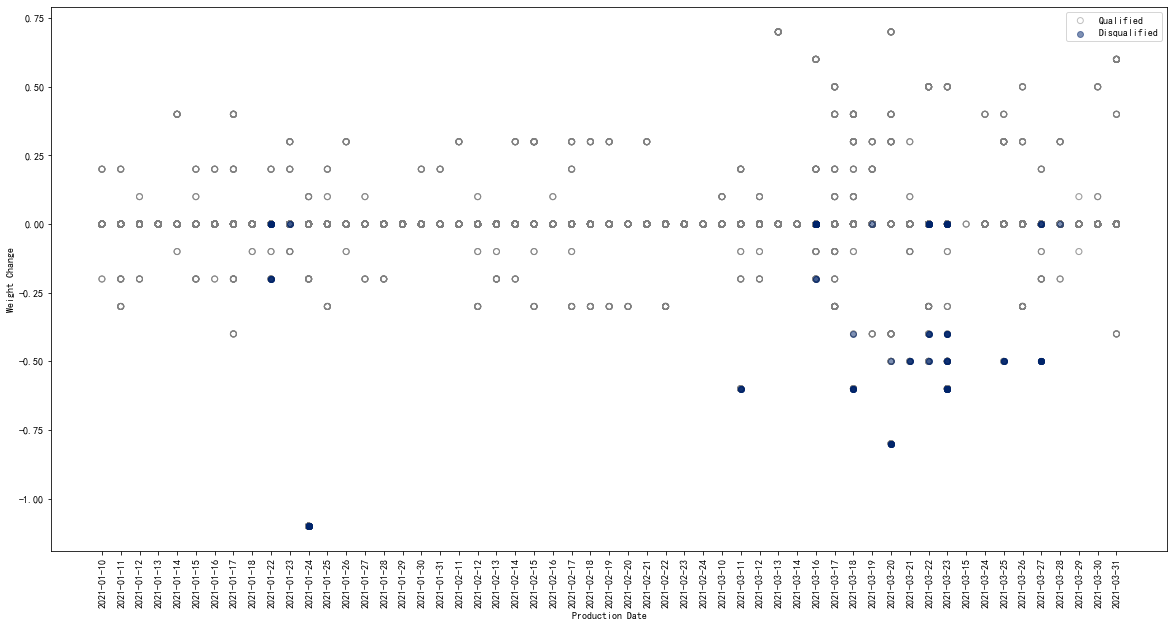

In [131]:
# The disqualified products might be driven by weight change during manufacturing
# Extrem negative (<-0.5g) weight change happened frequently in March

plt.figure(figsize=(20, 10))
plt.xticks(rotation=90)
plt.scatter(gloves_qualified['Date'].astype(str), gloves_qualified['WeightChange'], alpha=0.5, edgecolor='grey', facecolor='none', 
           label='Qualified')
plt.scatter(gloves_disqualified['Date'].astype(str), gloves_disqualified['WeightChange'], alpha=0.5, color='#00246A', label='Disqualified')
plt.xlabel('Production Date')
plt.ylabel('Weight Change')
plt.legend()

### 5.2. Weight Difference vs Weight Change

Text(0, 0.5, 'Weight Difference')

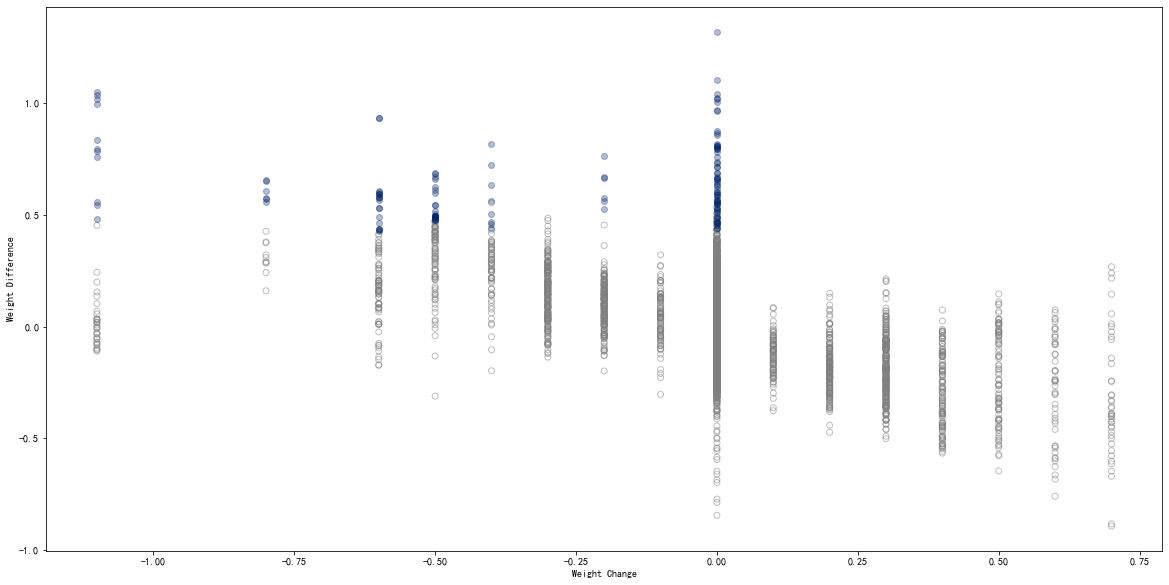

In [129]:
# View the relationship between weight difference and weight change
# I found that the disqualified products happend only when the weight change is less or equal to 0

plt.figure(figsize=(20, 10))
plt.scatter(gloves_qualified['WeightChange'], gloves_qualified['WeightDiff'], alpha=0.5, edgecolor='grey', facecolor='none', 
           label='Qualified')
plt.scatter(gloves_disqualified['WeightChange'], gloves_disqualified['WeightDiff'], alpha=0.3, color='#00246A', label='Disqualified')
plt.xlabel('Weight Change')
plt.ylabel('Weight Difference')

In [144]:
# Compare the disqualification ratio among different weight changes

disqualified_wc = gloves_disqualified.groupby('WeightChange').count()
qualified_wc = gloves_qualified.groupby('WeightChange').count()
merge_wc = pd.merge(qualified_wc['Disqualification'], disqualified_wc['Disqualification'], 
                    left_index=True, right_index=True, how='outer')
merge_wc.fillna(0, inplace=True)
merge_wc['DisqualificationRatio'] = merge_wc['Disqualification_y'] / merge_wc['Disqualification_x'] 
merge_wc[merge_wc['DisqualificationRatio'] > 0]

,Disqualification_x,Disqualification_y,DisqualificationRatio
WeightChange,,,
-1.1,33,11.0,0.333333
-0.8,10,6.0,0.600000
-0.6,77,19.0,0.246753
-0.5,84,22.0,0.261905
-0.4,54,8.0,0.148148
-0.2,84,4.0,0.047619
-0.2,106,2.0,0.018868
0.0,47785,65.0,0.001360


Text(0.5, 0, 'Disqualification Ratio')

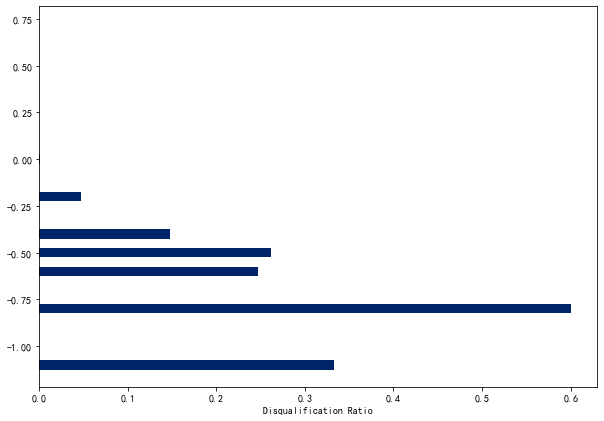

In [154]:
# Negative weight change more than 0.2 leads to a dramastic increase in disqualification ratio

plt.figure(figsize=(10, 7))
plt.barh(merge_wc.index, merge_wc['DisqualificationRatio'], height=0.05, color='#00246A')
plt.xlabel('Disqualification Ratio')

### 5.3. Weight Difference vs Manufacturing Time

Text(0, 0.5, 'Weight Difference')

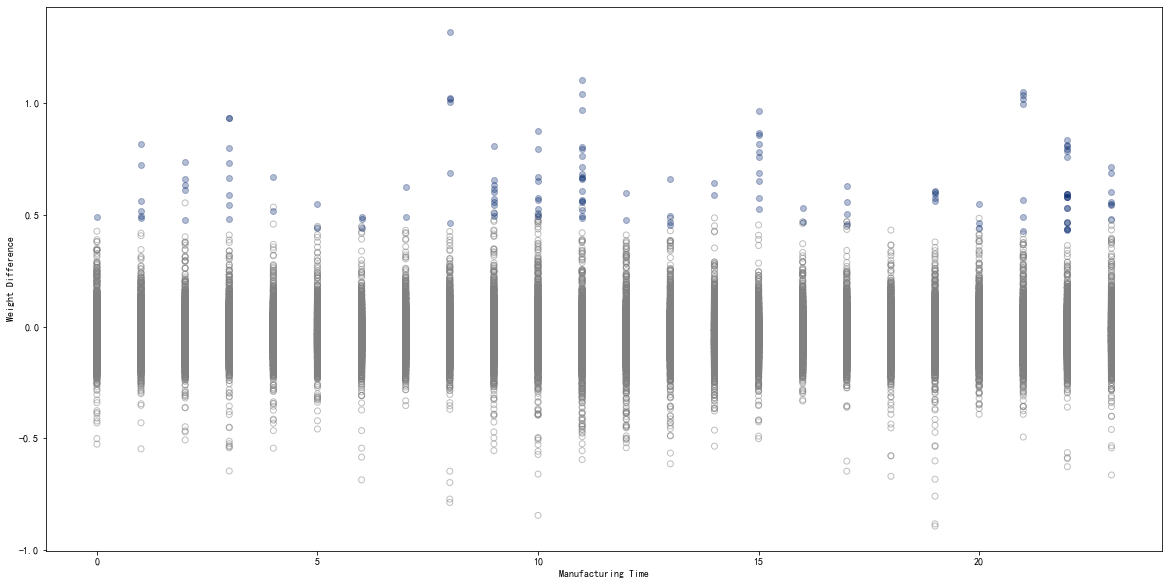

In [132]:
# There is no significant impact of manufacturing time on disqualification 
# as the disqualified samples distributed randomly across all the manufacturing time

plt.figure(figsize=(20, 10))
plt.scatter(gloves_qualified['Time'], gloves_qualified['WeightDiff'], alpha=0.5, edgecolor='grey', facecolor='none', 
           label='Qualified')
plt.scatter(gloves_disqualified['Time'], gloves_disqualified['WeightDiff'], alpha=0.3, color='#00246A', label='Disqualified')
plt.xlabel('Manufacturing Time')
plt.ylabel('Weight Difference')

Text(0, 0.5, 'Weight Change')

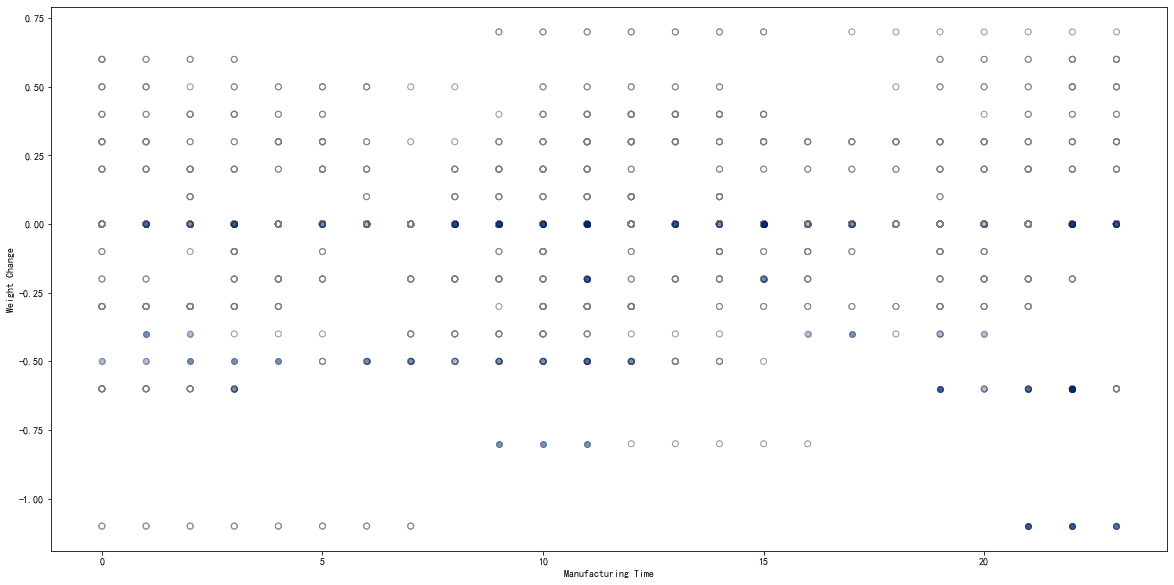

In [133]:
# Weight changes across the working time

plt.figure(figsize=(20, 10))
plt.scatter(gloves_qualified['Time'], gloves_qualified['WeightChange'], alpha=0.5, edgecolor='grey', facecolor='none', 
           label='Qualified')
plt.scatter(gloves_disqualified['Time'], gloves_disqualified['WeightChange'], alpha=0.3, color='#00246A', label='Disqualified')
plt.xlabel('Manufacturing Time')
plt.ylabel('Weight Change')

In [149]:
# Compare the disqualification ratio among different manufacturing time

disqualified_time = gloves_disqualified.groupby('Time').count()
qualified_time = gloves_qualified.groupby('Time').count()
merge_time = pd.merge(qualified_time['Disqualification'], disqualified_time['Disqualification'], 
                    left_index=True, right_index=True, how='outer')
merge_time.fillna(0, inplace=True)
merge_time['DisqualificationRatio'] = merge_time['Disqualification_y'] / merge_time['Disqualification_x'] 
merge_time[merge_time['DisqualificationRatio'] > 0]

,Disqualification_x,Disqualification_y,DisqualificationRatio
Time,,,
0,2129,1.0,0.000470
1,2134,6.0,0.002812
2,2121,5.0,0.002357
3,2082,8.0,0.003842
4,2064,2.0,0.000969
5,2050,2.0,0.000976
6,2053,3.0,0.001461
7,1962,2.0,0.001019
8,2018,6.0,0.002973


Text(0.5, 0, 'Disqualification Ratio')

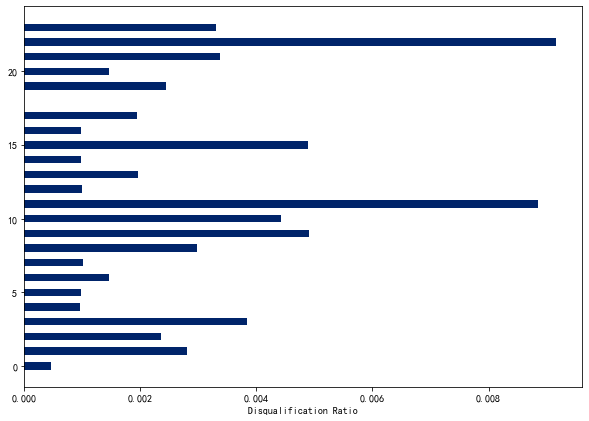

In [155]:
# Manufactruing time at 22 and 11 have a comparatively higher disqualification ratio

plt.figure(figsize=(10, 7))
plt.barh(merge_time.index, merge_time['DisqualificationRatio'], height=0.5, color='#00246A')
plt.xlabel('Disqualification Ratio')

### 5.4. Weight Difference vs Production Line

Text(0, 0.5, 'Weight Difference')

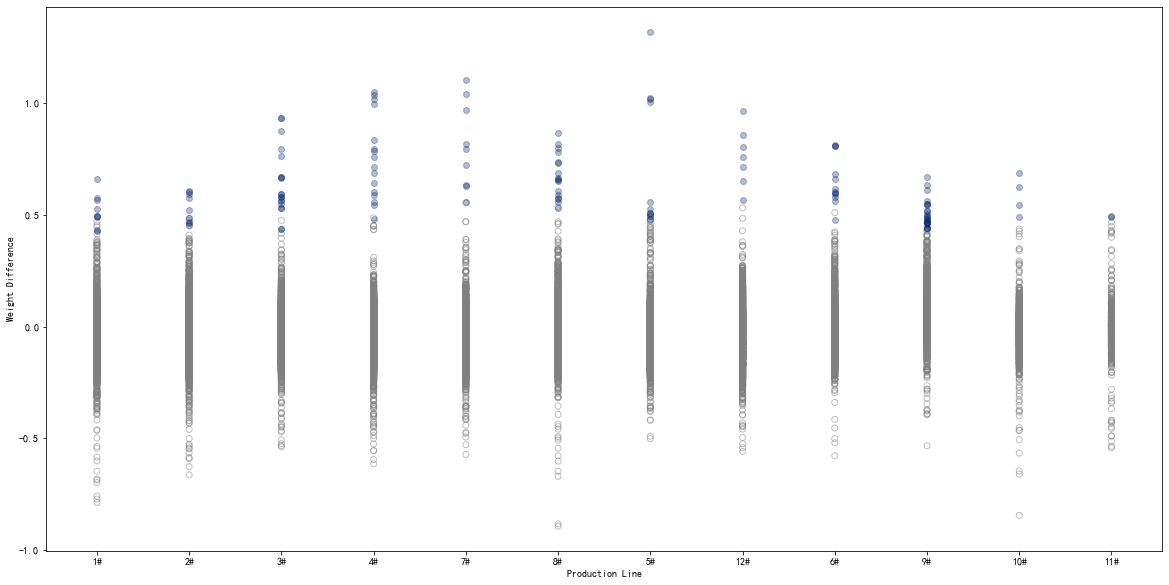

In [134]:
# There is no significant impact of production line on disqualification 
# as the disqualified samples distributed randomly across all the production lines

plt.figure(figsize=(20, 10))
plt.scatter(gloves_qualified['ProductionLine'], gloves_qualified['WeightDiff'], alpha=0.5, edgecolor='grey', facecolor='none', 
           label='Qualified')
plt.scatter(gloves_disqualified['ProductionLine'], gloves_disqualified['WeightDiff'], alpha=0.3, color='#00246A', label='Disqualified')
plt.xlabel('Production Line')
plt.ylabel('Weight Difference')

Text(0, 0.5, 'Weight Change')

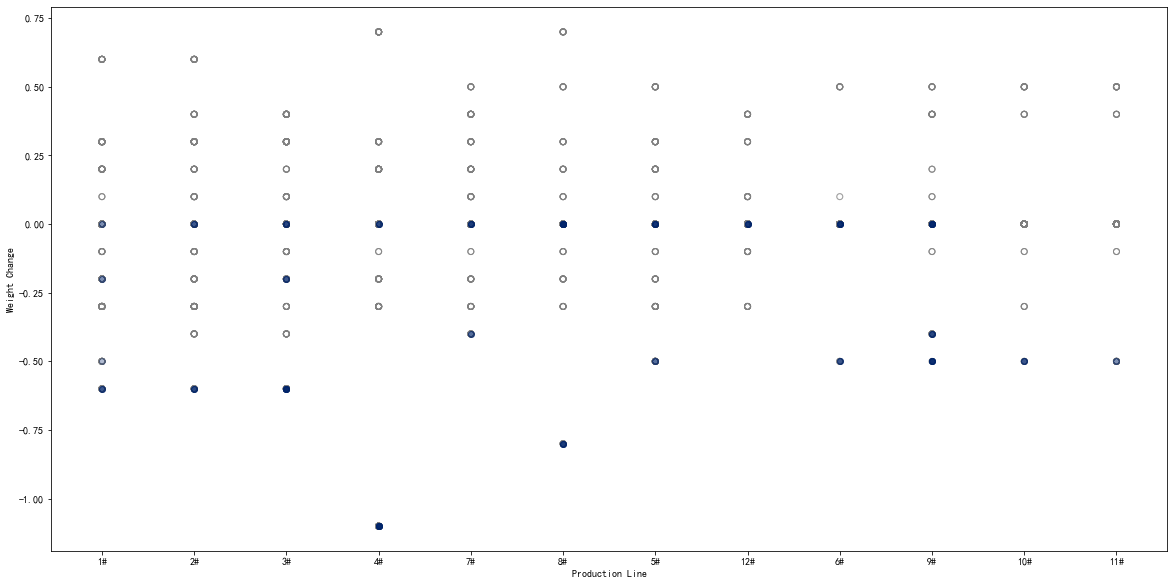

In [135]:
# Weight changes across the production line

plt.figure(figsize=(20, 10))
plt.scatter(gloves_qualified['ProductionLine'], gloves_qualified['WeightChange'], alpha=0.5, edgecolor='grey', facecolor='none', 
           label='Qualified')
plt.scatter(gloves_disqualified['ProductionLine'], gloves_disqualified['WeightChange'], alpha=0.3, color='#00246A', label='Disqualified')
plt.xlabel('Production Line')
plt.ylabel('Weight Change')

In [156]:
# Compare the disqualification ratio among different production lines

disqualified_pl = gloves_disqualified.groupby('ProductionLine').count()
qualified_pl = gloves_qualified.groupby('ProductionLine').count()
merge_pl = pd.merge(qualified_pl['Disqualification'], disqualified_pl['Disqualification'], 
                    left_index=True, right_index=True, how='outer')
merge_pl.fillna(0, inplace=True)
merge_pl['DisqualificationRatio'] = merge_pl['Disqualification_y'] / merge_pl['Disqualification_x'] 
merge_pl[merge_pl['DisqualificationRatio'] > 0]

,Disqualification_x,Disqualification_y,DisqualificationRatio
ProductionLine,,,
1#,6899,9,0.001305
10#,676,4,0.005917
11#,690,2,0.002899
12#,3557,7,0.001968
2#,6907,9,0.001303
3#,6817,19,0.002787
4#,6908,16,0.002316
5#,5654,10,0.001769
6#,2612,12,0.004594


Text(0.5, 0, 'Disqualification Ratio')

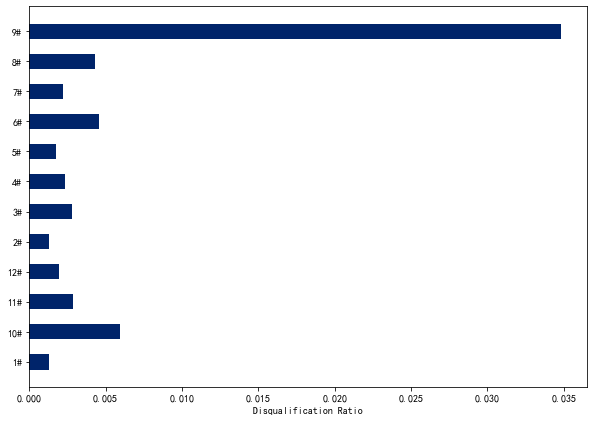

In [157]:
# Production Line #9 has a significantly higher level of disqualification ratio

plt.figure(figsize=(10, 7))
plt.barh(merge_pl.index, merge_pl['DisqualificationRatio'], height=0.5, color='#00246A')
plt.xlabel('Disqualification Ratio')

### 5.5. Weight Difference vs Measuring Surface

Text(0, 0.5, 'Weight Difference')

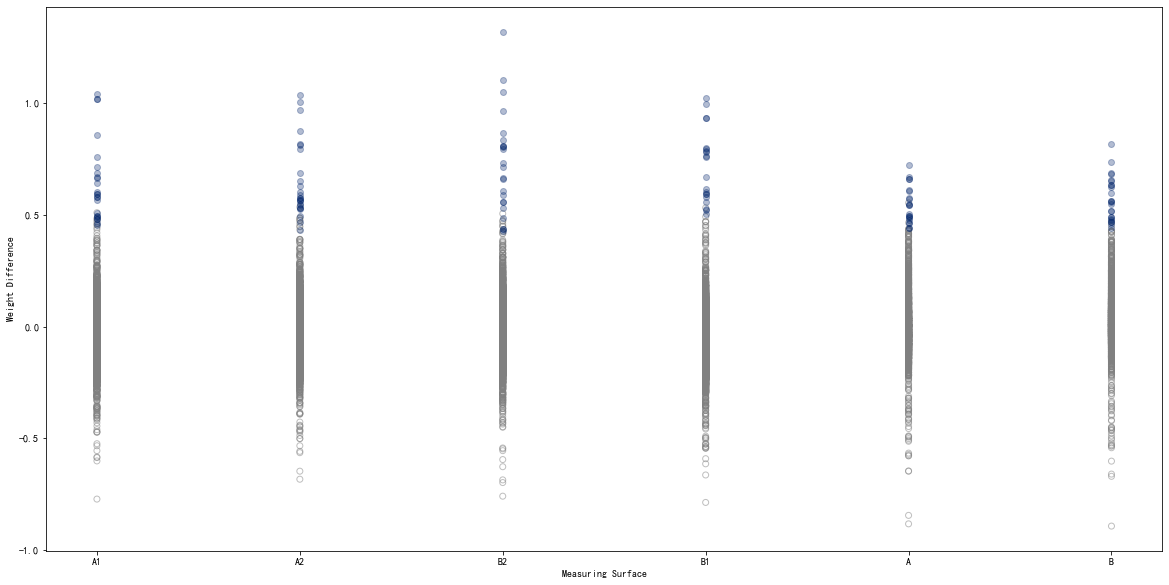

In [136]:
# There is no significant impact of measuring surface on disqualification 
# as the disqualified samples distributed randomly across all the measuring surfaces

plt.figure(figsize=(20, 10))
plt.scatter(gloves_qualified['Surface'], gloves_qualified['WeightDiff'], alpha=0.5, edgecolor='grey', facecolor='none', 
           label='Qualified')
plt.scatter(gloves_disqualified['Surface'], gloves_disqualified['WeightDiff'], alpha=0.3, color='#00246A', label='Disqualified')
plt.xlabel('Measuring Surface')
plt.ylabel('Weight Difference')

Text(0, 0.5, 'Weight Change')

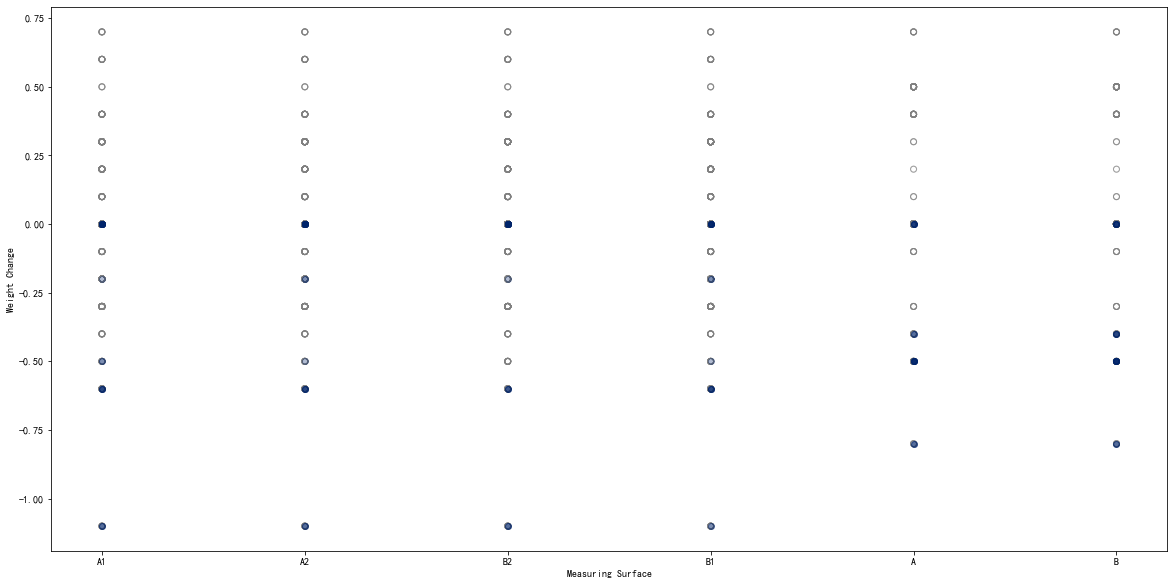

In [137]:
# Weight changes across the meausring surface

plt.figure(figsize=(20, 10))
plt.scatter(gloves_qualified['Surface'], gloves_qualified['WeightChange'], alpha=0.5, edgecolor='grey', facecolor='none', 
           label='Qualified')
plt.scatter(gloves_disqualified['Surface'], gloves_disqualified['WeightChange'], alpha=0.3, color='#00246A', label='Disqualified')
plt.xlabel('Measuring Surface')
plt.ylabel('Weight Change')

In [158]:
# Compare the disqualification ratio among different measuring surfaces

disqualified_s = gloves_disqualified.groupby('Surface').count()
qualified_s = gloves_qualified.groupby('Surface').count()
merge_s = pd.merge(qualified_s['Disqualification'], disqualified_s['Disqualification'], 
                    left_index=True, right_index=True, how='outer')
merge_s.fillna(0, inplace=True)
merge_s['DisqualificationRatio'] = merge_s['Disqualification_y'] / merge_s['Disqualification_x'] 
merge_s[merge_s['DisqualificationRatio'] > 0]

,Disqualification_x,Disqualification_y,DisqualificationRatio
Surface,,,
A,2032,21,0.010335
A1,11324,24,0.002119
A2,11323,25,0.002208
B,2029,24,0.011828
B1,11328,20,0.001766
B2,11325,23,0.002031


Text(0.5, 0, 'Disqualification Ratio')

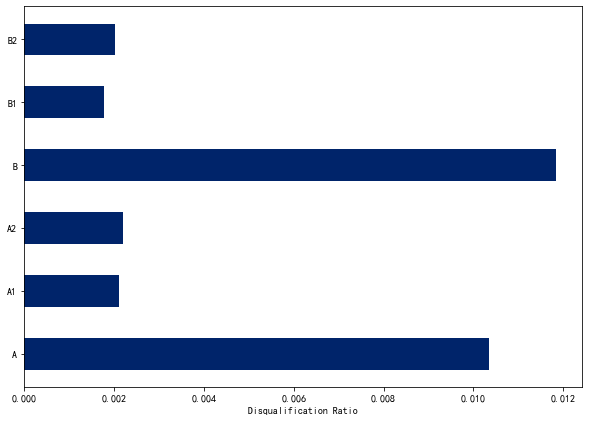

In [159]:
# Surface A and B have a significant higher level of disqualification ratio

plt.figure(figsize=(10, 7))
plt.barh(merge_s.index, merge_s['DisqualificationRatio'], height=0.5, color='#00246A')
plt.xlabel('Disqualification Ratio')

### 5.6. Weight Difference vs Work Shift

Text(0, 0.5, 'Weight Difference')

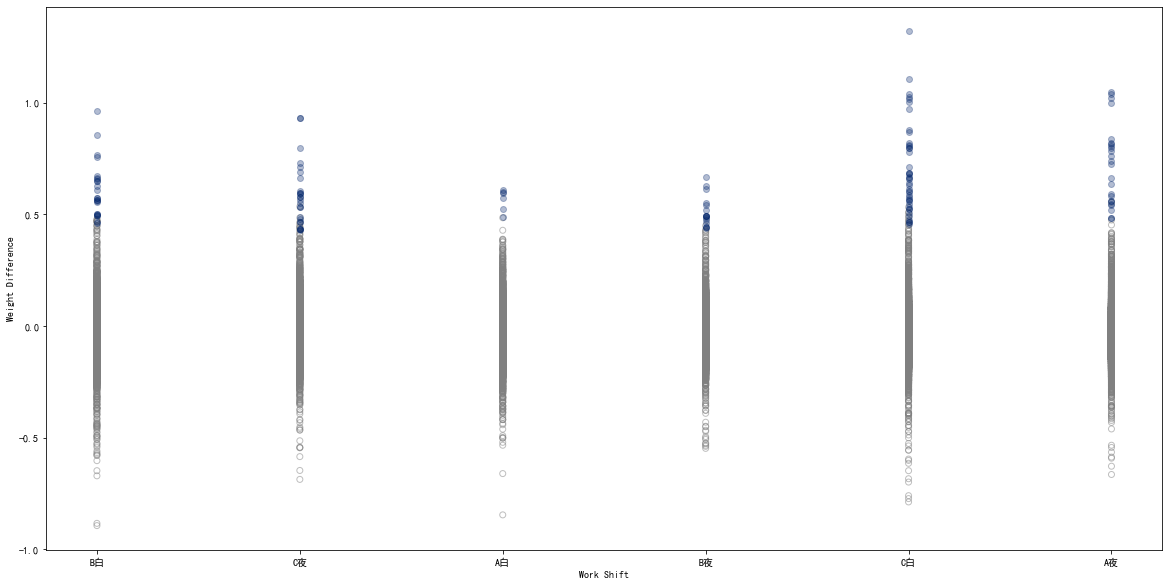

In [138]:
# There is no significant impact of working shift on disqualification 
# as the disqualified samples distributed randomly across all the working shifts

plt.figure(figsize=(20, 10))
plt.scatter(gloves_qualified['Shift'], gloves_qualified['WeightDiff'], alpha=0.5, edgecolor='grey', facecolor='none', 
           label='Qualified')
plt.scatter(gloves_disqualified['Shift'], gloves_disqualified['WeightDiff'], alpha=0.3, color='#00246A', label='Disqualified')
plt.xlabel('Work Shift')
plt.ylabel('Weight Difference')

Text(0, 0.5, 'Weight Change')

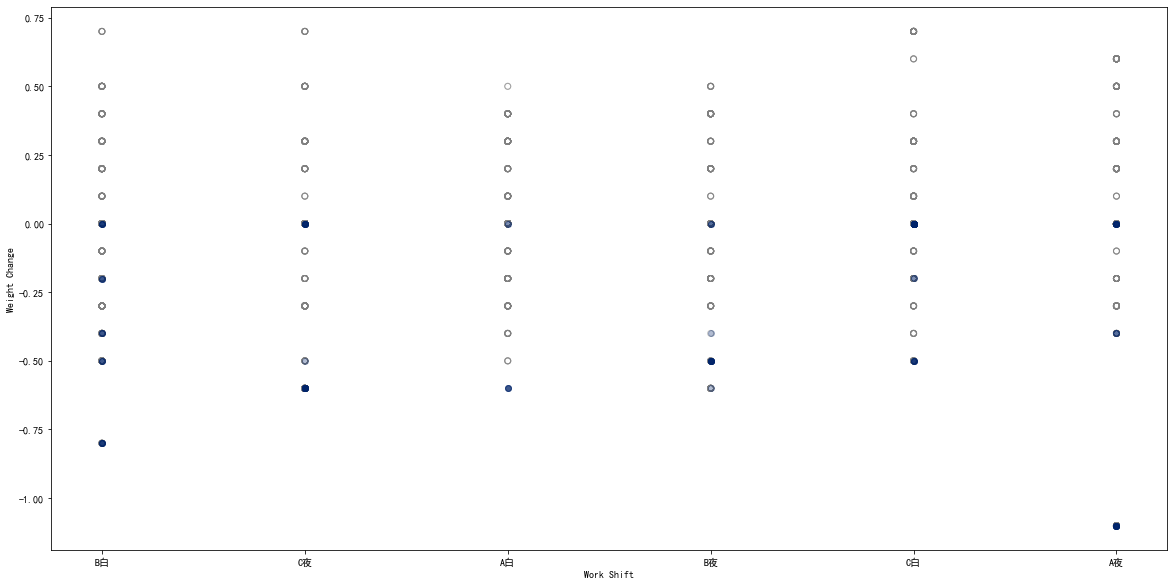

In [139]:
# Weight changes across the working shifts

plt.figure(figsize=(20, 10))
plt.scatter(gloves_qualified['Shift'], gloves_qualified['WeightChange'], alpha=0.5, edgecolor='grey', facecolor='none', 
           label='Qualified')
plt.scatter(gloves_disqualified['Shift'], gloves_disqualified['WeightChange'], alpha=0.3, color='#00246A', label='Disqualified')
plt.xlabel('Work Shift')
plt.ylabel('Weight Change')

In [160]:
# Compare the disqualification ratio among different working shifts

disqualified_sh = gloves_disqualified.groupby('Shift').count()
qualified_sh = gloves_qualified.groupby('Shift').count()
merge_sh = pd.merge(qualified_sh['Disqualification'], disqualified_sh['Disqualification'], 
                    left_index=True, right_index=True, how='outer')
merge_sh.fillna(0, inplace=True)
merge_sh['DisqualificationRatio'] = merge_sh['Disqualification_y'] / merge_sh['Disqualification_x'] 
merge_sh[merge_sh['DisqualificationRatio'] > 0]

,Disqualification_x,Disqualification_y,DisqualificationRatio
Shift,,,
A夜,8608,24,0.002788
A白,7376,6,0.000813
B夜,7620,16,0.002100
B白,8808,24,0.002725
C夜,8695,25,0.002875
C白,8254,42,0.005088


Text(0.5, 0, 'Disqualification Ratio')

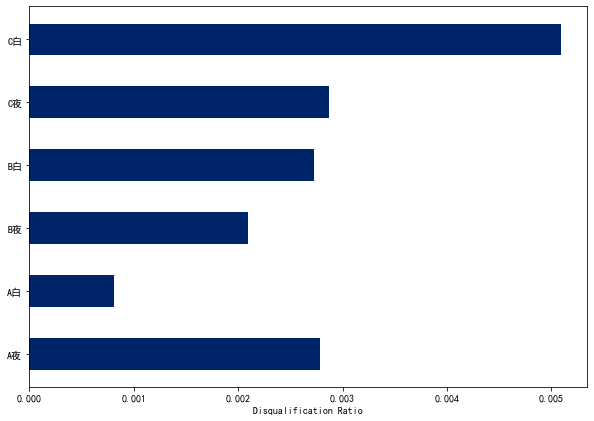

In [162]:
# Shift of C at day time have a comparatively higher level of disqualification ratio

plt.figure(figsize=(10, 7))
plt.barh(merge_sh.index, merge_sh['DisqualificationRatio'], height=0.5, color='#00246A')
plt.xlabel('Disqualification Ratio')

## 6. Summary

The take-home message is that a **negative weight change more than 0.2** leads to a dramastic increase in disqualification ratio.  

Some other minor information includes:  
1. Manufactruing time at 22 and 11 have a comparatively higher disqualification ratio.
2. Production Line #9 has a significantly higher level of disqualification ratio.  
3. Surface A and B have a significantly higher level of disqualification ratio.  
4. Shift of C at day time have a comparatively higher level of disqualification ratio.